# Classifieur KNN
Le classifieur KNN est assez simple et possède peu d'hyperparamètres, il sera donc facile à optimiser. On s'attend aussi à un bon résultat parce que les caractéristiques extraites devraient être assez représentatives des différentes espèces de feuilles.

In [1]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()

(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur KNN, on utilise 3 hyperparamètres :
- Le nombre de voisins
- La pondération associée à chaque voisin : uniforme (sans pondération) ou selon la distance
- La métrique de distance

L'hyperparamètre le plus important est évidemment le nombre de voisin. Cependant, ce sera intéressant de voir si les autres hyperparamètres auront un impact significatif sur les performances du modèle.

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [2]:
hyperparameters = {
    'n_neighbors': range(1,10),
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan', 'cosine']   
}

grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, refit=True, verbose = 1, cv=5)
grid.fit(dataset.x_train, dataset.t_train)
print('Best:', grid.best_params_)

columns = ['param_'+param for param in hyperparameters.keys()]
columns.append('mean_test_score')
columns.append('rank_test_score')

results = pd.DataFrame(grid.cv_results_, columns=columns)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


## Évaluation

Le nombre de voisin optimal est 4, ce qui veut dire qu'on se base sur très peu de points pour déterminer l'espèce d'une feuille. On peut regarder les scores de tous les modèles à 1 voisin pour voir l'impact des autres hyperparamètres.

In [3]:
results.query('param_n_neighbors == 4')

,param_n_neighbors,param_weights,param_metric,mean_test_score,rank_test_score
6,4,distance,euclidean,0.855698,30
7,4,uniform,euclidean,0.818215,43
24,4,distance,manhattan,0.932166,1
25,4,uniform,manhattan,0.904775,12
42,4,distance,cosine,0.880242,22
43,4,uniform,cosine,0.836920,37


Les distances euclidiennes et cosinus sont assez similaire, mais la distance de manhattan est significativement différente et toujours supérieure.

On remarque aussi que pondérer les voisins selon la distance donne toujours un meilleur résultat, ce qui est assez logique; plus on voisin est loin, moins il a de chance d'appartenir à la même classe.

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

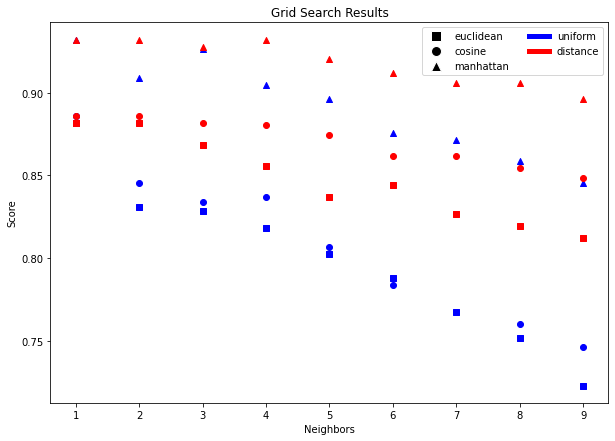

In [4]:
plt.figure(figsize=(10,7))

plt.scatter(results.query('param_metric == "euclidean" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "euclidean" and param_weights == "uniform"')['mean_test_score'],
            marker='s', color='blue')
plt.scatter(results.query('param_metric == "cosine" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "cosine" and param_weights == "uniform"')['mean_test_score'],
            marker='o', color='blue')
plt.scatter(results.query('param_metric == "manhattan" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "manhattan" and param_weights == "uniform"')['mean_test_score'],
            marker='^', color='blue')
plt.scatter(results.query('param_metric == "euclidean" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "euclidean" and param_weights == "distance"')['mean_test_score'],
            marker='s', color='red')
plt.scatter(results.query('param_metric == "cosine" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "cosine" and param_weights == "distance"')['mean_test_score'],
            marker='o', color='red')
plt.scatter(results.query('param_metric == "manhattan" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "manhattan" and param_weights == "distance"')['mean_test_score'],
            marker='^', color='red')

plt.xlabel("Neighbors")
plt.ylabel("Score")
plt.title("Grid Search Results")

legend = [
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='euclidean'), 
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='cosine'), 
    plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='manhattan'),
    plt.Line2D([0], [0], color='blue', linewidth=5, label='uniform'),
    plt.Line2D([0], [0], color='red', linewidth=5, label='distance')
    ]
plt.legend(handles=legend, ncols=2)

plt.show()

On remarque la distance de manhattan est toujours meilleure que les distances euclidienne et cosinus, et la pondération des voisins selon la distance est toujours meilleure que la pondération uniforme.

De plus, le score commence à décroitre lorsque le nombre de voisins est supérieur à 4. C'est assez logique; notre ensemble d'entrainement contient très peu de données par classe donc si on regarde beaucoup de voisins, la majorité d'entre eux appartiendront à des classes différentes. La décroissance est encore plus grande sans pondération, justement parce qu'on accorde trop d'importance aux voisins éloignés qui sont dans des classes différentes.

Au final, il est donc assez logique que le nombre optimal de voisin soit 4.

## Test

Accuracy  : 95.2862%
f1_score  : 0.95 ± 0.1041
precision : 0.964 ± 0.09469
recall    : 0.9529 ± 0.1348


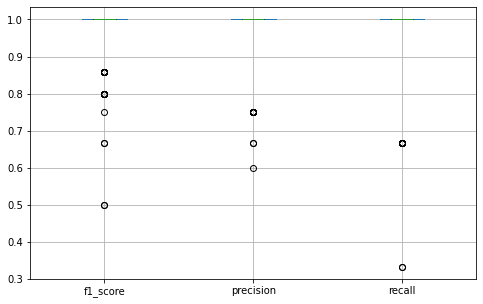

In [5]:
# TODO Explain evaluation metrics   

test_preds = grid.predict(dataset.x_test)
acc, reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)